In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\Potato",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1500 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

47

(32, 256, 256, 3)
[1 1 1 2 2 2 1 2 2 1 0 0 2 2 0 0 0 0 1 1 2 2 2 0 0 1 0 2 0 1 0 2]


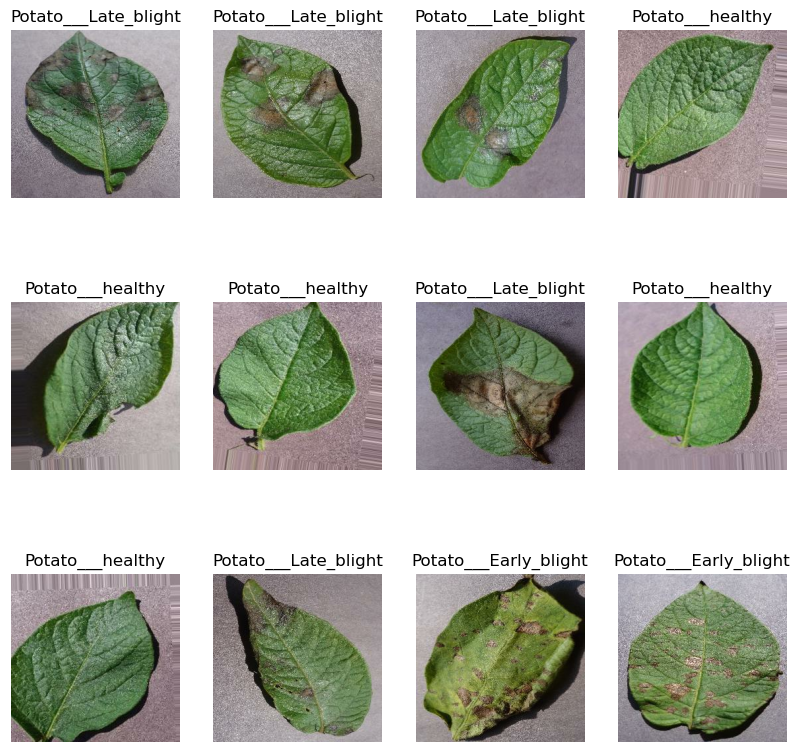

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.9, val_split=0.05, test_split=0.05, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

42 2 3


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
42/42 [==============================] - 49s 1s/step - loss: 0.9645 - accuracy: 0.5015 - val_loss: 0.6454 - val_accuracy: 0.7656
Epoch 2/20
42/42 [==============================] - 50s 1s/step - loss: 0.6095 - accuracy: 0.7291 - val_loss: 0.4756 - val_accuracy: 0.7500
Epoch 3/20
42/42 [==============================] - 51s 1s/step - loss: 0.4625 - accuracy: 0.7851 - val_loss: 0.4734 - val_accuracy: 0.7812
Epoch 4/20
42/42 [==============================] - 50s 1s/step - loss: 0.3859 - accuracy: 0.8336 - val_loss: 0.4263 - val_accuracy: 0.8125
Epoch 5/20
42/42 [==============================] - 50s 1s/step - loss: 0.3588 - accuracy: 0.8612 - val_loss: 0.3013 - val_accuracy: 0.8750
Epoch 6/20
42/42 [==============================] - 52s 1s/step - loss: 0.3237 - accuracy: 0.8672 - val_loss: 0.1372 - val_accuracy: 0.9688
Epoch 7/20
42/42 [==============================] - 53s 1s/step - loss: 0.2958 - accuracy: 0.8873 - val_loss: 0.1767 - val_accuracy: 0.9531
Epoch 8/20
42/42 [==

In [13]:
scores=model.evaluate(test_ds)
scores

3/3 [==============================] - 1s 235ms/step - loss: 0.1488 - accuracy: 0.9479


[0.14880073070526123, 0.9479166865348816]

In [14]:
history.history['loss']

[0.9645363688468933,
 0.6094897985458374,
 0.4624727964401245,
 0.38587313890457153,
 0.35876065492630005,
 0.3237345516681671,
 0.29579073190689087,
 0.26560667157173157,
 0.24325226247310638,
 0.24073359370231628,
 0.1933712661266327,
 0.19665122032165527,
 0.19518056511878967,
 0.1643643081188202,
 0.12143661826848984,
 0.13526499271392822,
 0.15706177055835724,
 0.16365575790405273,
 0.12209613621234894,
 0.10409560799598694]

In [15]:
history.history['accuracy']

[0.5014925599098206,
 0.7291044592857361,
 0.7850746512413025,
 0.8335821032524109,
 0.8611940145492554,
 0.8671641945838928,
 0.8873134255409241,
 0.9029850959777832,
 0.904477596282959,
 0.9089552164077759,
 0.920895516872406,
 0.9343283772468567,
 0.920895516872406,
 0.9440298676490784,
 0.9582089781761169,
 0.9507462978363037,
 0.9447761178016663,
 0.9440298676490784,
 0.9559701681137085,
 0.9611940383911133]

In [16]:
history.history['val_loss']

[0.6454027891159058,
 0.47564780712127686,
 0.47340160608291626,
 0.4263353645801544,
 0.30128228664398193,
 0.13719093799591064,
 0.1766979992389679,
 0.12690411508083344,
 0.24247176945209503,
 0.1436758041381836,
 0.16111674904823303,
 0.17055799067020416,
 0.14572612941265106,
 0.23570415377616882,
 0.14268982410430908,
 0.17553269863128662,
 0.3318710923194885,
 0.18835392594337463,
 0.25962311029434204,
 0.15710178017616272]

In [17]:
history.history['val_accuracy']

[0.765625,
 0.75,
 0.78125,
 0.8125,
 0.875,
 0.96875,
 0.953125,
 0.953125,
 0.921875,
 0.953125,
 0.953125,
 0.90625,
 0.9375,
 0.890625,
 0.953125,
 0.921875,
 0.859375,
 0.953125,
 0.90625,
 0.9375]

In [18]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

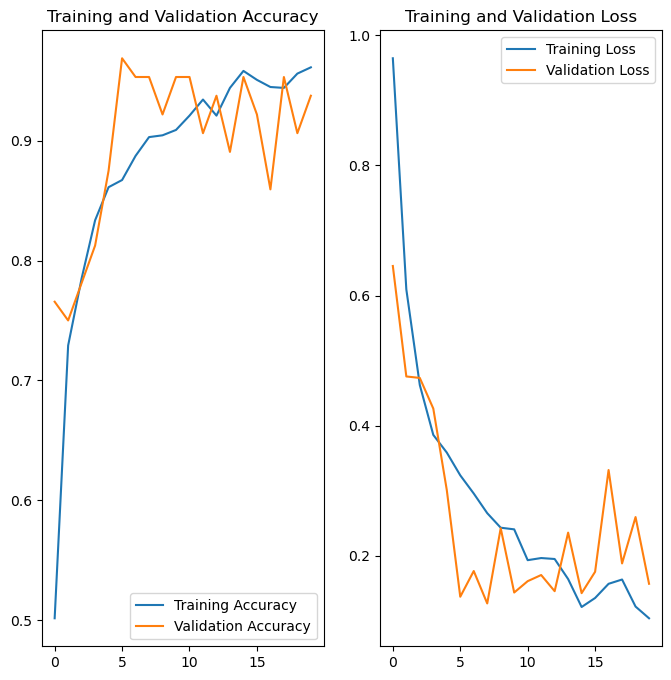

In [19]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [21]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(3):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 316ms/step


In [22]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


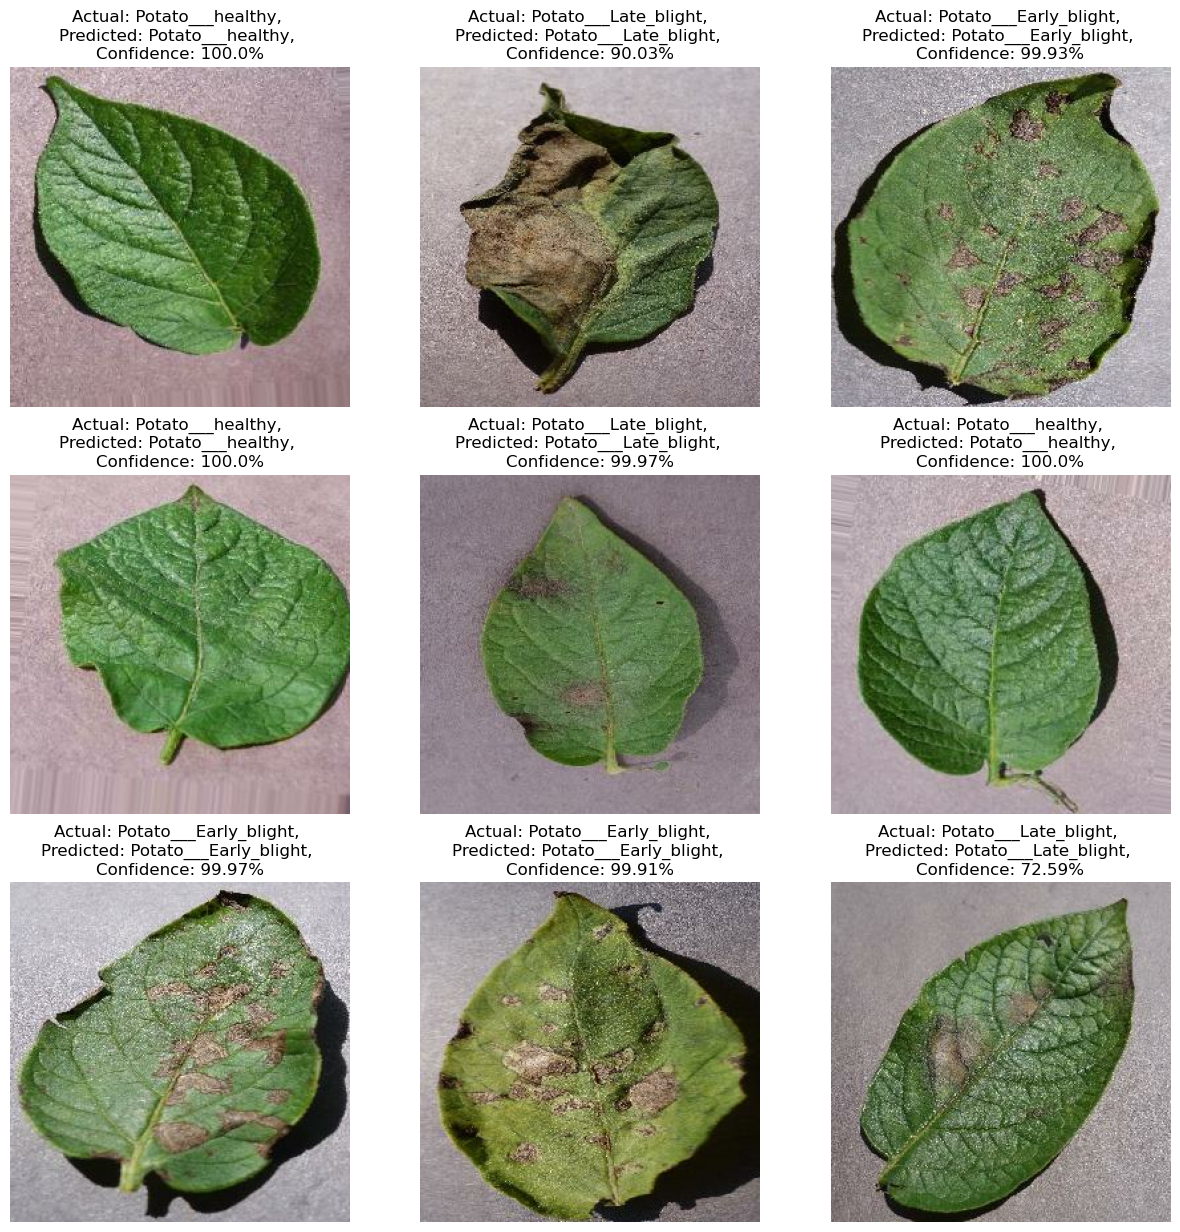

In [23]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [24]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.89      1.00      0.94        34
           1       0.97      0.89      0.93        37
           2       1.00      0.96      0.98        25

    accuracy                           0.95        96
   macro avg       0.96      0.95      0.95        96
weighted avg       0.95      0.95      0.95        96



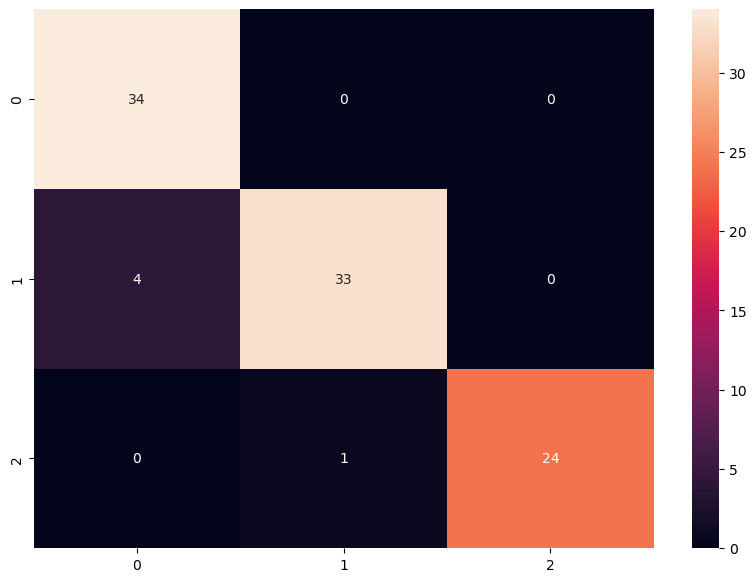

In [25]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [26]:
filename = "Model1-2-DatasetSplit90-5-5.joblib"
joblib.dump(model, filename)

['Model1-2-DatasetSplit90-5-5.joblib']